# Fixing the contrast level of 100nm images

In [146]:
a = np.random.rand(50, 128,128) 
b = np.random.rand(50, 128,128) 
x = []
x.append(a)
x.append(b)
x = np.array(x).reshape(100,128,128)
x.shape

(100, 128, 128)

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, '100nm')

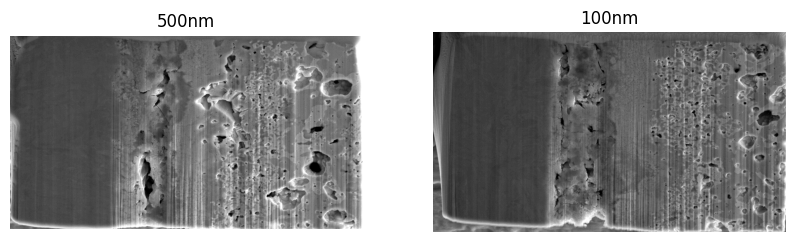

In [126]:
src_500nm, src_100nm = "../datasets/FIB Tomography/images/", "../datasets/100nm/Images/Aligned SEM Images/"
im_500nm, im_100nm = [im for im in os.listdir(src_500nm) if ".tif" in im], [im for im in os.listdir(src_100nm) if ".tif" in im]

idx = 10
img500, img100 = cv2.imread(src_500nm + im_500nm[idx],0), cv2.imread(src_100nm + im_100nm[idx],0)
plt.figure(figsize=(10,10))
plt.subplot(221);plt.imshow(img500, cmap="gray");plt.axis(False);plt.title("500nm")
plt.subplot(222);plt.imshow(img100, cmap="gray");plt.axis(False);plt.title("100nm")

In [22]:
print(im_500nm[0])

SEM Image - SliceImage - 121.tif


Text(0.5, 1.0, '100nm')

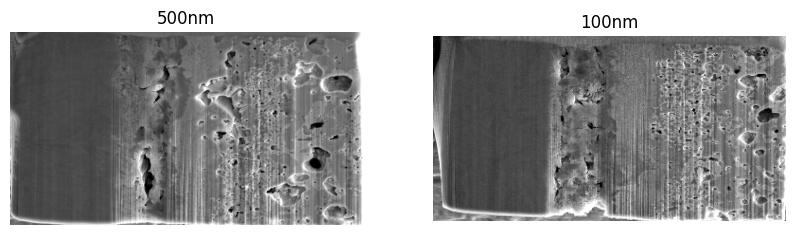

In [26]:
from skimage.exposure import match_histograms

# Match the histogram of 100nm to 500nm
matched_img100 = match_histograms(img100, img500)

# Normalized
plt.figure(figsize=(10,10))
plt.subplot(221);plt.imshow(img500, cmap="gray");plt.axis(False);plt.title("500nm")
plt.subplot(222);plt.imshow(matched_img100, cmap="gray");plt.axis(False);plt.title("100nm")

# Testing 100nm images with pretrained models

In [82]:
from models import multi_unet_model, attention_unet, residual_unet
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from patchify import patchify
from tqdm import tqdm
from evaluate import *

# from dataset2 import *

attention = "../results/models/EPOCHS100_ATTENTION_categorical_crossentropy_esFalse_augTrue/attention.hdf5"
residual = "../results/models/EPOCHS100_RESIDUAL_categorical_crossentropy_esFalse_augTrue/residual.hdf5"
unet = "../results/models/EPOCHS300_UNET_focal_esFalse_augTrue/unet.hdf5"

In [83]:
mkpaths = ['../datasets/FIB Tomography/Labels/.ipynb_checkpoints', '../datasets/FIB Tomography/Labels/001.png', '../datasets/FIB Tomography/Labels/002.png', '../datasets/FIB Tomography/Labels/003.png', '../datasets/FIB Tomography/Labels/005.png', '../datasets/FIB Tomography/Labels/007.png', '../datasets/FIB Tomography/Labels/009.png', '../datasets/FIB Tomography/Labels/011.png', '../datasets/FIB Tomography/Labels/013.png', '../datasets/FIB Tomography/Labels/015.png', '../datasets/FIB Tomography/Labels/017.png', '../datasets/FIB Tomography/Labels/019.png', '../datasets/FIB Tomography/Labels/021.png', '../datasets/FIB Tomography/Labels/023.png', '../datasets/FIB Tomography/Labels/025.png', '../datasets/FIB Tomography/Labels/027.png', '../datasets/FIB Tomography/Labels/029.png', '../datasets/FIB Tomography/Labels/031.png', '../datasets/FIB Tomography/Labels/033.png', '../datasets/FIB Tomography/Labels/035.png', '../datasets/FIB Tomography/Labels/037.png', '../datasets/FIB Tomography/Labels/039.png', '../datasets/FIB Tomography/Labels/041.png', '../datasets/FIB Tomography/Labels/043.png', '../datasets/FIB Tomography/Labels/045.png', '../datasets/FIB Tomography/Labels/047.png', '../datasets/FIB Tomography/Labels/049.png', '../datasets/FIB Tomography/Labels/051.png', '../datasets/FIB Tomography/Labels/053.png', '../datasets/FIB Tomography/Labels/055.png', '../datasets/FIB Tomography/Labels/057.png', '../datasets/FIB Tomography/Labels/059.png', '../datasets/FIB Tomography/Labels/061.png', '../datasets/FIB Tomography/Labels/063.png', '../datasets/FIB Tomography/Labels/065.png', '../datasets/FIB Tomography/Labels/067.png', '../datasets/FIB Tomography/Labels/069.png', '../datasets/FIB Tomography/Labels/071.png', '../datasets/FIB Tomography/Labels/073.png', '../datasets/FIB Tomography/Labels/075.png', '../datasets/FIB Tomography/Labels/077.png', '../datasets/FIB Tomography/Labels/079.png', '../datasets/FIB Tomography/Labels/081.png', '../datasets/FIB Tomography/Labels/083.png', '../datasets/FIB Tomography/Labels/085.png', '../datasets/FIB Tomography/Labels/087.png', '../datasets/FIB Tomography/Labels/089.png', '../datasets/FIB Tomography/Labels/091.png', '../datasets/FIB Tomography/Labels/093.png', '../datasets/FIB Tomography/Labels/095.png', '../datasets/FIB Tomography/Labels/097.png', '../datasets/FIB Tomography/Labels/099.png', '../datasets/FIB Tomography/Labels/101.png', '../datasets/FIB Tomography/Labels/103.png', '../datasets/FIB Tomography/Labels/105.png', '../datasets/FIB Tomography/Labels/107.png', '../datasets/FIB Tomography/Labels/109.png', '../datasets/FIB Tomography/Labels/111.png', '../datasets/FIB Tomography/Labels/113.png', '../datasets/FIB Tomography/Labels/115.png', '../datasets/FIB Tomography/Labels/117.png', '../datasets/FIB Tomography/Labels/119.png', '../datasets/FIB Tomography/Labels/121.png', '../datasets/FIB Tomography/Labels/123.png', '../datasets/FIB Tomography/Labels/125.png', '../datasets/FIB Tomography/Labels/127.png']
impaths = ['../datasets/FIB Tomography/images/SEM Image - SliceImage - 001.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 002.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 003.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 005.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 007.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 009.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 011.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 013.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 015.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 017.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 019.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 021.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 023.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 025.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 027.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 029.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 031.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 033.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 035.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 037.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 039.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 041.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 043.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 045.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 047.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 049.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 051.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 053.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 055.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 057.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 059.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 061.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 063.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 065.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 067.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 069.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 071.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 073.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 075.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 077.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 079.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 081.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 083.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 085.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 087.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 089.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 091.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 093.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 095.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 097.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 099.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 101.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 103.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 105.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 107.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 109.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 111.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 113.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 115.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 117.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 119.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 121.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 123.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 125.tif', '../datasets/FIB Tomography/images/SEM Image - SliceImage - 127.tif']
impaths, mkpaths = [im for im in impaths if ".tif" in im], [im for im in mkpaths if ".png" in im]

# Load Test Images

In [99]:
from skimage.exposure import match_histograms
from tensorflow.keras.utils import normalize

# load reference
ref = cv2.imread("../datasets/FIB Tomography/images/SEM Image - SliceImage - 121.tif",0)
src_100nm = "../datasets/FIB Tomography/images/"
src_labels = "../datasets/FIB Tomography/Labels/"
im_100nm = [im for im in os.listdir(src_100nm) if ".tif" in im][:10]
test_images = np.array([cv2.resize(cv2.imread(src_100nm+im,0), (1280,640), interpolation=cv2.INTER_NEAREST) for im in im_100nm])

labels = [im for im in os.listdir(src_labels) if ".png" in im][:10]
test_labels = np.array([cv2.resize(cv2.imread(src_labels+im,0), (1280,640), interpolation=cv2.INTER_NEAREST) for im in labels])
 # Normalize datasets
test_images = normalize(test_images, axis=1)
print(test_labels.shape)

(10, 640, 1280)


# Extract Patches

In [63]:
from patchify import patchify, unpatchify

def patchify_dataset(images):
    test_images = []
    print(len(images))
    for i in range(len(images)):
        tmp = []
        p = (128,256)# desired patch size
        image_patches = patchify(images[i],(p[0],p[1]), step=p[0])
        for x in range(len(image_patches)):
            for y in range(len(image_patches[0])):
                tmp.append(image_patches[x,y,:,:]);
        test_images.append(tmp)
    print("Total Images: ", len(test_images))
    return np.array(test_images)

test_im_patches = patchify_dataset(test_images)
print("Test images: ", test_im_patches.shape)

50


ValueError: `window_shape` is incompatible with `arr_in.shape`

In [30]:
image = test_images[0]  # Example image
patches = patchify(image, (128,128), step=128)  # Create patches

In [100]:
def patchify_dataset(images):
    test_images = []
    print(len(images))
    for i in range(len(images)):
        tmp = []
        p = (128,128)# desired patch size
        image_patches = patchify(images[i],(p[0],p[1]), step=p[0])
        for x in range(len(image_patches)):
            for y in range(len(image_patches[0])):
                tmp.append(image_patches[x,y,:,:]);
        test_images.append(tmp)
    print("Total Images: ", len(test_images))
    return np.array(test_images)

test_im_patches = patchify_dataset(test_images)
test_msk_patches = patchify_dataset(test_labels)
print("Test images: ", test_im_patches.shape)

10
Total Images:  10
10
Total Images:  10
Test images:  (10, 50, 128, 128)


(640, 1280)


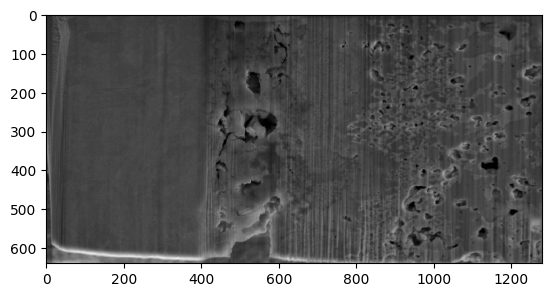

In [86]:
original = test_images[5]
image_patches = patchify(original,(128,128), step=128)
image_patches.shape

# reshape for training
train_images = image_patches.reshape(50, 128, 128)
train_images.shape

# reshape for testing
reshaped = train_images.reshape(5, 10, 128, 128)
reshaped.shape


reconstructed_image = unpatchify(reshaped, original.shape)
print(reconstructed_image.shape)
plt.imshow(reconstructed_image, cmap="gray")

In [109]:
img = test_im_patches[0]

# Reshape the array into a 5 x 10 matrix
reshaped_images = img.reshape(5, 10, 128, 128)

# Verify the new shape
print("Original shape:", img.shape)
print("Reshaped shape:", reshaped_images.shape)

Original shape: (50, 128, 128)
Reshaped shape: (5, 10, 128, 128)


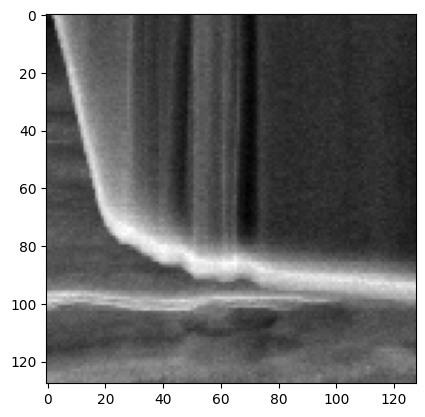

In [91]:
plt.imshow(patches[4, 0], cmap="gray")

(640, 1280)


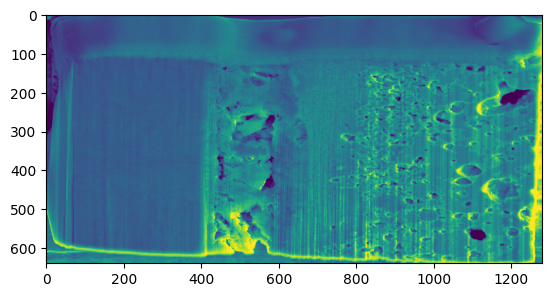

In [93]:
reconstructed_image = unpatchify(patches, image.shape)
print(reconstructed_image.shape)
plt.imshow(reconstructed_image)

# Load model

In [89]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

focal_loss = categorical_focal_loss(alpha=[[.15, .15, .25, .15, .15, .25]])

In [90]:
n_classes = 6
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS = 128, 128, 1

In [103]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
# def get_model():
#     return attention_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# def get_model():
#     return residual_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# start training
scores, iou_list, acc_list = {},[],[]
# initialize model
model = get_model()
# model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy']) 
model.load_weights(unet)

In [102]:
save_dir = '../'
scores, iou_list, acc_list = {},[],[]
X_test, y_test = test_im_patches[0], test_msk_patches[0]
scores = performance_evaluation(model, X_test, y_test, n_classes, scores,idx,save_dir) # calculate results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

# Test 100nm images

In [104]:
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

# def unpatch(patches):
#     final_image = np.zeros((256,256))
#     current_x = 0 # keep track of where your current image was last placed in the y coordinate
#     images = [patches[0,:,:64,0],patches[1,:,:,0]]
#     for image in images:
#         # add an image to the final array and increment the y coordinate
#         final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
#         current_x += image.shape[1]
#     new_image = final_image[:128,:64+128]
    
#     final_image = np.zeros((256,256))
#     current_x = 0 # keep track of where your current image was last placed in the y coordinate
#     images = [new_image[:,:128],patches[2,:,:,0]]
#     for image in images:
#         # add an image to the final array and increment the y coordinate
#         final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
#         current_x += image.shape[1]
#     return final_image[:128,:]

# def combine_patches(top,bot):
#     images = [top,bot]
#     final_image = np.zeros((256,256))
#     current_y = 0 # keep track of where your current image was last placed in the y coordinate
#     for image in images:
#         # add an image to the final array and increment the y coordinate
#         final_image[current_y:image.shape[0]+current_y,:image.shape[1]] = image
#         current_y += image.shape[0]
#     return final_image

# # def unpatchify(patches):
# #     top = unpatch(patches[0:4])
# #     bot = unpatch(patches[6:9])
# #     return combine_patches(top,bot)

def unpatch(patches):
    return unpatchify(patches[:,:,:,0].reshape(5, 10, 128, 128), (640, 1280))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


Text(0.5, 1.0, 'Prediction')

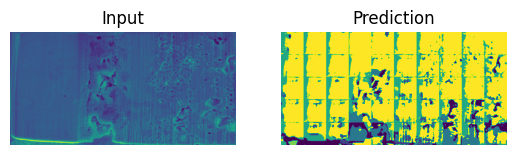

In [105]:
from tensorflow.keras.utils import to_categorical

X_test = test_im_patches[0]
y_pred=model.predict(X_test)  # Get Model Prediction
y_pred_argmax=np.argmax(y_pred, axis=3) # combine prediction to single image
pred = np.expand_dims(y_pred_argmax,axis=3)
X_test = np.expand_dims(X_test,axis=3)
if(X_test.shape[1] < 256):
    img,msk = unpatch(X_test),unpatch(pred) # unpatchify target and prediction
    predicted = to_categorical(msk, num_classes=n_classes) # split classes
else:
    img,gt,msk = X_test[0,:,:,0],y_test[0,:,:,0],pred[0,:,:,0] 
    target, predicted = y_test, pred

plt.subplot(221);plt.imshow(img);plt.axis(False);plt.title("Input")
plt.subplot(222);plt.imshow(msk);plt.axis(False);plt.title("Prediction")

## Save Image Patches

In [12]:
image_dir, mask_dir = "../datasets/patches/images", "../datasets/patches/labels"
if not os.path.exists(image_dir):
    os.makedirs(image_dir); os.makedirs(mask_dir)

# save patches
for i in tqdm(range(len(X_train))):
    idx = mkpaths[i].split('/')[-1].split('.')[0]
    for j in range(len(X_train[i])):
        img, mask = X_train[i,j], y_train[i,j]
        cv2.imwrite(os.path.join(image_dir, f'{j}_{idx}.tif'),img); cv2.imwrite(os.path.join(mask_dir, f'{j}_{idx}.png'),mask);

100%|██████████| 65/65 [00:14<00:00,  4.34it/s]


In [11]:
mkpaths[-1]

'../datasets/FIB Tomography/Labels/127.png'

In [ ]:
# do same for test images
image_dir, mask_dir = "../datasets/patches/images", "../datasets/patches/labels"


# save patches
for i in tqdm(range(len(X_test))):
    idx = mkpaths[i].split('/')[-1].split('.')[0]
    for j in range(len(X_train[i])):
        img, mask = X_test[i,j], y_test[i,j]
        cv2.imwrite(os.path.join(image_dir, f'{i}_{idx}.tif'),img); cv2.imwrite(os.path.join(mask_dir, f'{i}_{idx}.png'),mask);

## Save patches

In [13]:
X_train.shape

(2592, 128, 256, 1)

In [10]:
def unpatch(patches):
    final_image = np.zeros((256,256))
    current_x = 0 # keep track of where your current image was last placed in the y coordinate
    images = [patches[0,:,:64,0],patches[1,:,:,0]]
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
        current_x += image.shape[1]
    new_image = final_image[:128,:64+128]
    
    final_image = np.zeros((256,256))
    current_x = 0 # keep track of where your current image was last placed in the y coordinate
    images = [new_image[:,:128],patches[2,:,:,0]]
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[:image.shape[0],current_x:image.shape[1]+current_x] = image
        current_x += image.shape[1]
    return final_image[:128,:]

def combine_patches(top,bot):
    images = [top,bot]
    final_image = np.zeros((256,256))
    current_y = 0 # keep track of where your current image was last placed in the y coordinate
    for image in images:
        # add an image to the final array and increment the y coordinate
        final_image[current_y:image.shape[0]+current_y,:image.shape[1]] = image
        current_y += image.shape[0]
    return final_image

# def unpatchify(patches):
#     top = unpatch(patches[0:4])
#     bot = unpatch(patches[6:9])
#     return combine_patches(top,bot)

def unpatchify(patches):
    image_patches = np.zeros((5, 9, 128, 256))
    i,j = 0,0
    for idx in range(len(patches)):
        image_patches[i,j,:,:] = patches[idx,:,:,0]
        j+=1
        if j == 9:
            j=0
            i+=1
            
    p = (128,256)
    tmp = np.zeros((640,1280))
    for i in range(len(image_patches)):
        count = 0
        for j in range(len(image_patches[0])):
            if(j%2 == 0):
                tmp[p[0]*i:p[0]*(i+1), p[1]*count:p[1]*(count+1)] = image_patches[i,j,:,:]
                count += 1
    return tmp

Text(0.5, 1.0, 'Final Prediction')

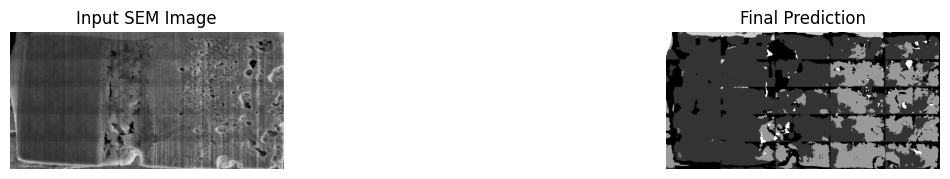

In [15]:
# save predictions images
# cv2.imwrite(f"{fig_directory}{slicex}.png",msk) # save prediction
plt.figure(figsize=(12, 8)); 
plt.subplot(231);plt.imshow(img,cmap="gray");plt.axis(False);plt.title("Input SEM Image")
# plt.subplot(232);plt.imshow(gt,cmap="gray");plt.axis(False);plt.title("Ground Truth ")
plt.subplot(233);plt.imshow(msk,cmap="gray");plt.axis(False);plt.title("Final Prediction")

In [42]:
import numpy as np

def reconstruct_image(patches, original_shape):
    """
    Reconstruct the original image from patches.

    Args:
        patches (numpy array): Array of image patches of shape (num_patches, patch_height, patch_width).
        original_shape (tuple): Shape of the original image (height, width).

    Returns:
        numpy array: Reconstructed image of shape `original_shape`.
    """
    # Get the number of patches along each dimension
    patch_height, patch_width = patches.shape[1], patches.shape[2]
    original_height, original_width = original_shape

    # Calculate the number of patches needed along each dimension
    num_patches_y = original_height // patch_height
    print(num_patches_y)
    num_patches_x = original_width // patch_width

    # Initialize an empty array for the reconstructed image
    reconstructed_image = np.zeros(original_shape, dtype=patches.dtype)

    # Reconstruct the image by placing patches in their correct positions
    patch_idx = 0
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            y_start = y * patch_height
            y_end = y_start + patch_height
            x_start = x * patch_width
            x_end = x_start + patch_width
            reconstructed_image[y_start:y_end, x_start:x_end] = patches[patch_idx]
            patch_idx += 1

    return reconstructed_image


In [29]:
# Example dimensions
original_shape = (640,1280)
patches = X_test[:,:,:,0]  # Replace with your patches

# Reconstruct the original image
reconstructed_image = reconstruct_image(patches, original_shape)

# Verify the shape
print(reconstructed_image.shape)  # Should print (1280, 640)

5
(640, 1280)


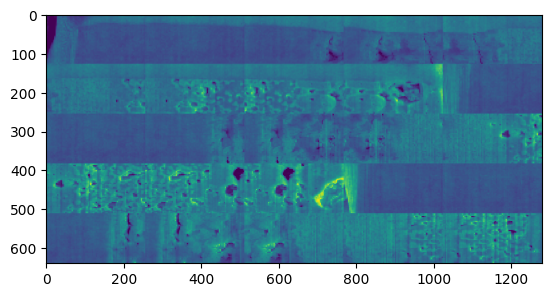

In [21]:
plt.imshow(reconstructed_image)